### Libary import

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# pip install lxml html5lib beautifulsoup4

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

In [2]:
pip install lxml html5lib beautifulsoup4

     |████████████████████████████████| 5.5MB 17.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 41.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Part 1. Data preprocessing

### Load LA neighborhood data

In [3]:
df_raw_LA=pd.read_csv('https://usc.data.socrata.com/api/views/9utn-waje/rows.csv?accessType=DOWNLOAD')
df_raw_LA.shape

(272, 14)

In [4]:
df_LA = df_raw_LA.loc[:,['name','latitude','longitude']]
df_LA.rename(columns={"name": "Neighborhood", "latitude": "Longitude1", 'longitude': 'Latitude'}, inplace=True)
df_LA["Longitude"]=df_LA["Longitude1"]
df_LA.drop("Longitude1", axis=1, inplace=True)

In [5]:
df_LA['Neighborhood'] = 'LA_'+df_LA['Neighborhood']
print(df_LA.shape)
df_LA.head()

(272, 3)


Neighborhood   Latitude   Longitude
0            LA_Acton  34.497355 -118.169810
1  LA_Adams-Normandie  34.031461 -118.300208
2     LA_Agoura Hills  34.146736 -118.759885
3       LA_Agua Dulce  34.504927 -118.317104
4         LA_Alhambra  34.085539 -118.136512

### Load NY neighborhood data

In [6]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_NY = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_NY = df_NY.append({'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Data downloaded!


In [7]:
df_NY['Neighborhood'] = 'NY_'+df_NY['Neighborhood']
print(df_NY.shape)
df_NY.head()

(306, 3)


Neighborhood   Latitude  Longitude
0    NY_Wakefield  40.894705 -73.847201
1   NY_Co-op City  40.874294 -73.829939
2  NY_Eastchester  40.887556 -73.827806
3    NY_Fieldston  40.895437 -73.905643
4    NY_Riverdale  40.890834 -73.912585

### Define Function to get city coordinate

In [8]:
def get_city_coordinate(address):
    geolocator = Nominatim(user_agent="city_explorer")
    location = geolocator.geocode(address)
    latitude_city = location.latitude
    longitude_city = location.longitude
    return(latitude_city,longitude_city)

### LA and NY city coordinates

In [9]:
address = 'New York, NY, US'
latitude_NY,longitude_NY = get_city_coordinate(address)
print('The geograpical coordinate of NY are {}, {}.'.format(latitude_NY, longitude_NY))

The geograpical coordinate of NY are 40.7127281, -74.0060152.


In [10]:
address = 'Los Angeles, CA, US'
latitude_LA, longitude_LA = get_city_coordinate(address)
print('The geograpical coordinate of LA are {}, {}.'.format(latitude_LA, longitude_LA))

The geograpical coordinate of LA are 34.0536909, -118.2427666.


### Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'AHZRNHEH0KR0CU5DJQDDDN3XMYZMRML3IUZSSS1C54NM1FF3' # your Foursquare ID
CLIENT_SECRET = 'UC3JLZGMPIDSB03V2NM35U0N1GFUOTN2JXCB4FBXAIXTEOZO' # your Foursquare Secret
VERSION = '20200709'     #'20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
RADIUS = 500 # define Foursquare API request radius

## Part 2. NY and LA neighborhoods

### 2.1 First let's see the NY and LA neighborhoods

In [12]:
# create map of NY using latitude and longitude values
map_NY = folium.Map(location=[latitude_NY, longitude_NY], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df_NY['Latitude'], df_NY['Longitude'],df_NY['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NY)  
    
map_NY

In [13]:
# create map of LA using latitude and longitude values
map_LA = folium.Map(location=[latitude_LA, longitude_LA], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df_LA['Latitude'], df_LA['Longitude'],df_LA['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

### 2.2 Define the Function and request venues

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        k = 0
        while k<3:
            rreet=requests.get(url).json()
            if rreet['meta']['code'] == 200:
                k =3
                results = rreet["response"]['groups'][0]['items']
                venues_list.append([(name, lat, lng, 
                                     v['venue']['id'], 
                                     v['venue']['name'], 
                                     v['venue']['location']['lat'], 
                                     v['venue']['location']['lng'], 
                                     v['venue']['categories'][0]['name']) for v in results])
                k+=1 
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['Neighborhood', 'Latitude', 'Longitude', 'Venue Id','Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

### Find NY and LA neighborhood venues and drop the duplicates

In [15]:
neighbor_venues_NY = getNearbyVenues(names=df_NY['Neighborhood'], latitudes=df_NY['Latitude'], longitudes=df_NY['Longitude'])
neighbor_venues_LA = getNearbyVenues(names=df_LA['Neighborhood'], latitudes=df_LA['Latitude'], longitudes=df_LA['Longitude'])

In [16]:
print(neighbor_venues_NY.shape)
neighbor_venues_NY.drop_duplicates(subset=['Venue Id'], inplace=True)
print(neighbor_venues_NY.shape)
neighbor_venues_NY.head()

(10090, 8)
(9553, 8)


Neighborhood   Latitude  Longitude                  Venue Id  \
0  NY_Wakefield  40.894705 -73.847201  4c537892fd2ea593cb077a28   
1  NY_Wakefield  40.894705 -73.847201  5d5f5044d0ae1c0008f043c3   
2  NY_Wakefield  40.894705 -73.847201  4c783cef3badb1f7e4244b54   
3  NY_Wakefield  40.894705 -73.847201  4d6af9426107f04dedeb297a   
4  NY_Wakefield  40.894705 -73.847201  4c25c212f1272d7f836385c5   

         Venue Name  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1         Walgreens       40.896528       -73.844700        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

In [17]:
print(neighbor_venues_LA.shape)
neighbor_venues_LA.drop_duplicates(subset=['Venue Id'], inplace=True)
print(neighbor_venues_LA.shape)
neighbor_venues_LA.head()

(2957, 8)
(2953, 8)


Neighborhood   Latitude   Longitude                  Venue Id  \
0            LA_Acton  34.497355 -118.169810  5a326a84345cbe5681ec1aaf   
1            LA_Acton  34.497355 -118.169810  549fa7db498e5892fb9a8275   
2  LA_Adams-Normandie  34.031461 -118.300208  5498d200498e8153c17c751a   
3  LA_Adams-Normandie  34.031461 -118.300208  5cdb759f15173e002c3af5a2   
4  LA_Adams-Normandie  34.031461 -118.300208  4d0825e043b36ea8189f2bef   

           Venue Name  Venue Latitude  Venue Longitude  \
0    Epik Engineering       34.498718      -118.168046   
1  Alma Gardening Co.       34.494762      -118.172550   
2   Orange Door Sushi       34.032485      -118.299368   
3               Shell       34.033095      -118.300025   
4         Little Xian       34.032292      -118.299465   

               Venue Category  
0  Construction & Landscaping  
1  Construction & Landscaping  
2            Sushi Restaurant  
3                 Gas Station  
4            Sushi Restaurant

### 2.3 Let's compare the Venue Category of the 2 city

#### Get total numbers of each type of venues and sort them

In [18]:
Venue_Category_sum_NY=neighbor_venues_NY.drop(['Neighborhood'], axis=1).groupby('Venue Category').count().iloc[:,0:1]
Venue_Category_sum_LA=neighbor_venues_LA.drop(['Neighborhood'], axis=1).groupby('Venue Category').count().iloc[:,0:1]
print(Venue_Category_sum_LA.shape, Venue_Category_sum_NY.shape)
Venue_Category_sum_LA.head()

(317, 1) (432, 1)


Latitude
Venue Category               
ATM                        12
Accessories Store           4
Airport                     1
Airport Terminal            1
American Restaurant        42

In [19]:
Venue_Category_sum_LA.rename(columns={'Latitude':'Number'}, inplace=True)
Venue_Category_sum_NY.rename(columns={'Latitude':'Number'}, inplace=True)
Venue_Category_sum_LA.sort_values(by=['Number'], ascending=False, inplace=True)
Venue_Category_sum_NY.sort_values(by=['Number'], ascending=False, inplace=True)
print(Venue_Category_sum_NY.shape,Venue_Category_sum_LA.shape)

(432, 1) (317, 1)


In [47]:
Venue_Category_sum_LA[:15]

Number
Venue Category              
Mexican Restaurant       135
Pizza Place               92
Coffee Shop               87
Fast Food Restaurant      77
Grocery Store             70
Bakery                    67
Convenience Store         66
Park                      62
Chinese Restaurant        58
Sandwich Place            58
Café                      47
Pharmacy                  46
Burger Joint              44
American Restaurant       42
Clothing Store            39

#### Let's see top 15 Categorie of Venues in each city

Text(0.5, 1.0, 'Top 15 Categorie of Venues in New York')

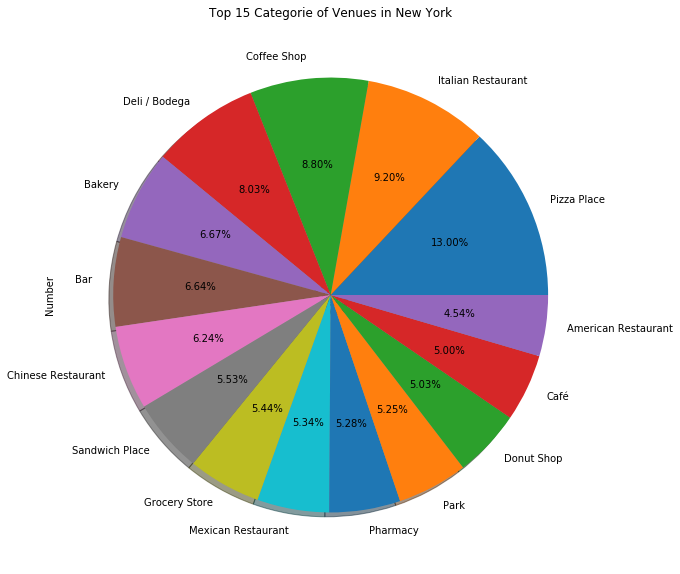

In [37]:
Venue_Category_sum_NY[:15].plot(kind='pie',subplots=True,figsize=(25,10),autopct='%1.2f%%',legend=None,
                               shadow=True)
plt.title('Top 15 Categorie of Venues in New York')

Text(0.5, 1.0, 'Top 15 Categorie of Venues in Los Angeles')

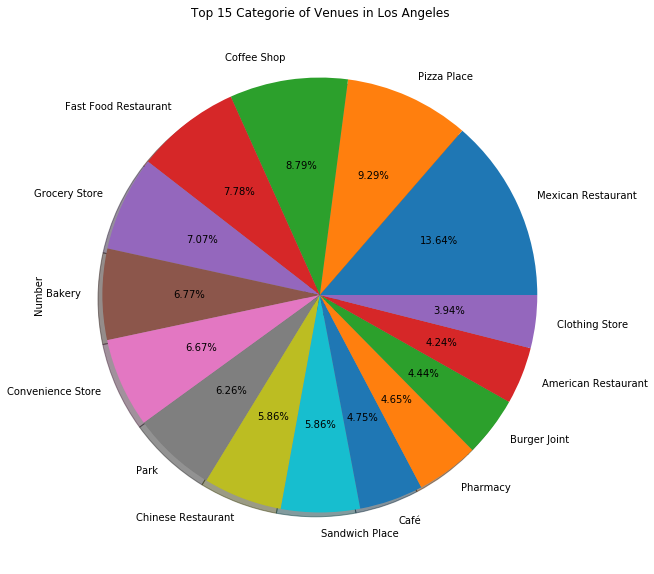

In [38]:
Venue_Category_sum_LA[:15].plot(kind='pie',subplots=True,figsize=(25,10),autopct='%1.2f%%',legend=None,
                               shadow=True)
plt.title('Top 15 Categorie of Venues in Los Angeles')

### 2.4 Encoding venue to numerical features and run KMeans to clusting

#### combine the 2 DataFrames and apply one-hot encoding

In [39]:
neighbor_venues_comb = pd.concat([neighbor_venues_NY, neighbor_venues_LA], ignore_index=True)
print(neighbor_venues_comb.shape)

# one hot encoding
onehot_neighbor_venues_comb = pd.get_dummies(neighbor_venues_comb[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot_neighbor_venues_comb['City_Neighborhood'] = neighbor_venues_comb['Neighborhood'] 

fixed_columns = [onehot_neighbor_venues_comb.columns[-1]] + list(onehot_neighbor_venues_comb.columns[:-1])
onehot_neighbor_venues_comb = onehot_neighbor_venues_comb[fixed_columns]

print(onehot_neighbor_venues_comb.shape)
onehot_neighbor_venues_comb.head()

(12506, 8)
(12506, 466)


City_Neighborhood  ATM  Accessories Store  Adult Boutique  \
0      NY_Wakefield    0                  0               0   
1      NY_Wakefield    0                  0               0   
2      NY_Wakefield    0                  0               0   
3      NY_Wakefield    0                  0               0   
4      NY_Wakefield    0                  0               0   

   Afghan Restaurant  African Restaurant  Airport  Airport Terminal  \
0                  0                   0        0                 0   
1                  0                   0        0                 0   
2                  0                   0        0                 0   
3                  0                   0        0                 0   
4                  0                   0        0                 0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0       0                 0   
1                    0             0       0                 0   
2                    0             0       0                 0   
3                    0             0       0                 0   
4                    0             0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                     0                 0                   0           0   
1                     0                 0                   0           0   
2                     0                 0                   0           0   
3                     0                 0                   0           0   
4                     0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                      0                    0            0              0   
1                      0                    0            0              0   
2                      0                    0            0              0   
3                      0                    0            0              0   
4                      0                    0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0                0          0           0           0       0     0    0   
1                0          0           0           0       0     0    0   
2                0          0           0           0       0     0    0   
3                0          0           0           0       0     0    0   
4                0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Bath House  Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0           0      0          0                0         0            0   
1           0      0          0                0         0            0   
2           0      0          0                0         0            0   
3           0      0          0                0         0            0   
4           0      0          0                0         0            0   

   Beer Store  Big Box Store  Bike Rental / Bike Sh

#### Group neighborhood and get neighborhood features

In [40]:
cities_grouped = onehot_neighbor_venues_comb.groupby('City_Neighborhood').mean().reset_index()
print(cities_grouped.shape)
cities_grouped.head()

(537, 466)


City_Neighborhood  ATM  Accessories Store  Adult Boutique  \
0            LA_Acton  0.0                0.0             0.0   
1  LA_Adams-Normandie  0.0                0.0             0.0   
2     LA_Agoura Hills  0.0                0.0             0.0   
3       LA_Agua Dulce  0.0                0.0             0.0   
4         LA_Alhambra  0.0                0.0             0.0   

   Afghan Restaurant  African Restaurant  Airport  Airport Terminal  \
0                0.0                 0.0      0.0               0.0   
1                0.0                 0.0      0.0               0.0   
2                0.0                 0.0      0.0               0.0   
3                0.0                 0.0      1.0               0.0   
4                0.0                 0.0      0.0               0.0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0             0.000000           0.0     0.0               0.0   
1             0.000000           0.0     0.0               0.0   
2             0.038462           0.0     0.0               0.0   
3             0.000000           0.0     0.0               0.0   
4             0.000000           0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0                  0.0   
1                     0.0          0.0         0.0                  0.0   
2                     0.0          0.0         0.0                  0.0   
3                     0.0          0.0         0.0                  0.0   
4                     0.0          0.0         0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                   0.0               0.0                 0.0         0.0   
1                   0.0               0.0                 0.0         0.0   
2                   0.0               0.0                 0.0         0.0   
3                   0.0               0.0                 0.0         0.0   
4                   0.0               0.0                 0.0         0.0   

   Australian Restaurant  Austrian Restaurant  Auto Garage  Auto Workshop  \
0                    0.0                  0.0          0.0            0.0   
1                    0.0                  0.0          0.0            0.0   
2                    0.0                  0.0          0.0            0.0   
3                    0.0                  0.0          0.0            0.0   
4                    0.0                  0.0          0.0            0.0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop    Bakery  Bank  Bar  \
0              0.0   0.000000         0.0    0.000000  0.000000   0.0  0.0   
1              0.0   0.000000         0.0    0.000000  0.000000   0.0  0.0   
2              0.0   0.038462         0.0    0.000000  0.038462   0.0  0.0   
3              0.0   0.000000         0.0    0.000000  0.000000   0.0  0.0   
4              0.0   0.000000         0.0    0.071429  0.000000   0.0  0.0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0             0.0               0.0               0.0                 0.0   
1             0.0               0.0               0.0                 0.0   
2             0.0               0.0               0.0                 0.0   
3             0.0               0.0               0.0                 0.0   
4             0.0               0.0               0.0                 0.0   

   Bath House  Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0         0.0    0.0        0.0              0.0       0.0          0.0   
1         0.0    0.0        0.0              0.0       0.0          0.0   
2         0.0    0.0        0.0              0.0       0.0          0.0   
3         0.0    0.0        0.0              0.0       0.0          0.0   
4         0.0    0.0        0.0              0.0       0.0          0.0   

   Beer Store  Big Box Store 

#### Run k-means to cluster the neighborhood into 10 clusters

In [41]:
# set number of clusters
kclusters = 10
cities_grouped_clustering = cities_grouped.drop('City_Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 3, 3, 1, 6, 3, 4, 4, 3, 1, 4,
       9, 4, 4, 2, 4, 4, 4, 8, 3, 4, 3, 4, 9, 6, 6, 4, 4, 4, 4, 7, 4, 1,
       1, 1, 4, 3, 1, 4, 1, 4, 4, 4, 3, 1, 3, 3, 1, 4, 4, 4, 3, 4, 4, 4,
       1, 4, 4, 3, 4, 4, 4, 5, 4, 4, 0, 1, 4, 1, 6, 4, 3, 1, 1, 6, 0, 3,
       1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 1, 6, 4, 1,
       0, 4, 4, 4, 4, 4, 3, 3, 3, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 3, 4, 4,
       4, 4, 3, 6, 4, 5, 4, 1, 1, 4, 1, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 3,
       4, 4, 3, 6, 4, 4, 4, 5, 4, 1, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 4, 4, 3, 3, 6, 4, 4, 4, 4, 4, 3, 4, 1, 4, 4, 4, 5, 5, 4,
       4, 6, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 1, 4,
       4, 4, 3, 6, 4, 1, 1, 4, 1, 4, 6, 4, 1, 4, 4, 4, 1, 1, 1, 1, 1, 4,
       4, 1, 4, 1, 4, 4, 4, 1, 4, 4, 1, 4, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4,
       1, 4, 4, 4, 1, 1, 1, 4, 1, 4, 1, 4, 4, 4, 1, 4, 4, 1, 1, 4, 4, 4,
       4, 4, 1, 4, 1, 4, 4, 4, 1, 1, 4, 1, 1, 1, 1,

### 2.5 Label clustering result and merge with coordinate for plotting

#### Label neighborhood

In [42]:
cities_grouped['label'] = kmeans.labels_
cities_grouped_clustering = cities_grouped[['City_Neighborhood', 'label']]
print(cities_grouped_clustering.shape)
cities_grouped_clustering.head()

(537, 2)


City_Neighborhood  label
0            LA_Acton      0
1  LA_Adams-Normandie      4
2     LA_Agoura Hills      4
3       LA_Agua Dulce      4
4         LA_Alhambra      4

#### Merge labels and neighborhood positions

In [43]:
df_cities = pd.concat([df_NY, df_LA], ignore_index=True)
df_cities.shape

(578, 3)

In [44]:
df_merged_labeled = df_cities
df_merged_labeled = df_merged_labeled.join(cities_grouped_clustering.set_index('City_Neighborhood'), on='Neighborhood', how='inner')
df_merged_labeled[['label']]=df_merged_labeled[['label']].astype(int)
print(df_merged_labeled.shape)
df_merged_labeled.head()

(541, 4)


Neighborhood   Latitude  Longitude  label
0    NY_Wakefield  40.894705 -73.847201      1
1   NY_Co-op City  40.874294 -73.829939      1
2  NY_Eastchester  40.887556 -73.827806      1
3    NY_Fieldston  40.895437 -73.905643      4
4    NY_Riverdale  40.890834 -73.912585      4

### 2.6 Create map for the result clusting

In [45]:
# create map
map_clusters_NY = folium.Map(location=[latitude_NY, longitude_NY], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged_labeled['Latitude'], df_merged_labeled['Longitude'],\
                                  df_merged_labeled['Neighborhood'], df_merged_labeled['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_NY)
       
map_clusters_NY

In [46]:
# create map
map_clusters_LA = folium.Map(location=[latitude_LA, longitude_LA], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged_labeled['Latitude'], df_merged_labeled['Longitude'],\
                                  df_merged_labeled['Neighborhood'], df_merged_labeled['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_LA)
       
map_clusters_LA

## Part 3. City similarity comparison

### 3.1 Foursquare request Function define and get venues of city

In [12]:
def getNearbyVenues_City(name, lat, lng, radius):
    venues_list=[]
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()["response"]['groups'][0]['items']
    venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Ciry Latitude', 
                  'City Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

#### Request venues

In [13]:
venues_ny = getNearbyVenues_City(name="NY", lat=latitude_NY, lng=longitude_NY,radius = RADIUS)
print(venues_ny.shape)
venues_ny.head()

(100, 7)


City  Ciry Latitude  City Longitude                Venue Name  \
0   NY      40.712728      -74.006015        Aire Ancient Baths   
1   NY      40.712728      -74.006015  9/11 Memorial North Pool   
2   NY      40.712728      -74.006015                 Crown Shy   
3   NY      40.712728      -74.006015    One World Trade Center   
4   NY      40.712728      -74.006015     The Rooftop @ Pier 17   

   Venue Latitude  Venue Longitude Venue Category  
0       40.718141       -74.004941            Spa  
1       40.712077       -74.013187  Memorial Site  
2       40.706187       -74.007490     Restaurant  
3       40.713069       -74.013133       Building  
4       40.705463       -74.001598    Music Venue

In [14]:
venues_la = getNearbyVenues_City(name="LA", lat=latitude_LA, lng=longitude_LA,radius = RADIUS)
print(venues_la.shape)
venues_la.head()

(100, 7)


City  Ciry Latitude  City Longitude                         Venue Name  \
0   LA      34.053691     -118.242767           Walt Disney Concert Hall   
1   LA      34.053691     -118.242767                 The Last Bookstore   
2   LA      34.053691     -118.242767               Grand Central Market   
3   LA      34.053691     -118.242767  Mr. Speedy Plumbing & Rooter Inc.   
4   LA      34.053691     -118.242767                 Vista Hermosa Park   

   Venue Latitude  Venue Longitude Venue Category  
0       34.055511      -118.249284   Concert Hall  
1       34.047620      -118.249852      Bookstore  
2       34.050675      -118.248741         Market  
3       34.042538      -118.233864   Home Service  
4       34.061601      -118.256857           Park

### 3.2 One-Hot encoding Function define and feature vectors

In [15]:
def oneHotEncoding_City(venues):
    onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
    onehot['City'] = venues['City']
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    return(onehot)

In [16]:
onehot_la = oneHotEncoding_City(venues_la)
onehot_la.head()

City  American Restaurant  Art Museum  Bakery  Basketball Stadium  \
0   LA                    0           0       0                   0   
1   LA                    0           0       0                   0   
2   LA                    0           0       0                   0   
3   LA                    0           0       0                   0   
4   LA                    0           0       0                   0   

   Bookstore  Breakfast Spot  Brewery  Café  Climbing Gym  Coffee Shop  \
0          0               0        0     0             0            0   
1          1               0        0     0             0            0   
2          0               0        0     0             0            0   
3          0               0        0     0             0            0   
4          0               0        0     0             0            0   

   Concert Hall  Deli / Bodega  Dessert Shop  Farmers Market  Film Studio  \
0             1              0             0               0            0   
1             0              0             0               0            0   
2             0              0             0               0            0   
3             0              0             0               0            0   
4             0              0             0               0            0   

   Food Truck  Fountain  French Restaurant  Garden  German Restaurant  \
0           0         0                  0       0                  0   
1           0         0                  0       0                  0   
2           0         0                  0       0                  0   
3           0         0                  0       0                  0   
4           0         0                  0       0                  0   

   Grocery Store  Gym  Gymnastics Gym  Home Service  Hotel  Ice Cream Shop  \
0              0    0               0             0      0               0   
1              0    0               0             0      0               0   
2              0    0               0             0      0               0   
3              0    0               0             1      0               0   
4              0    0               0             0      0               0   

   Italian Restaurant  Japanese Restaurant  Korean Restaurant  \
0                   0                    0                  0   
1                   0                    0                  0   
2                   0                    0                  0   
3                   0                    0                  0   
4                   0                    0                  0   

   Latin American Restaurant  Liquor Store  Market  Mediterranean Restaurant  \
0                          0             0       0                         0   
1                          0             0       0                         0   
2                          0             0       1                         0   
3                          0             0       0                         0   
4                          0             0       0                         0   

   Men's Store  Movie Theater  Multiplex  Museum  Music Venue  Neighborhood  \
0            0              0          0       0            0             0   
1            0              0          0       0            0             0   
2            0              0          0       0            0             0   
3            0              0          0       0            0             0   
4            0              0          0       0            0             0   

   New American Restaurant  Observatory  Park  Pizza Place  Rock Club  \
0                        0            0     0            0          0   
1                        0            0     0            0          0   
2                        0            0     0            0          0   
3                        0            0     0            0          0   
4                        0            0     1  

In [17]:
onehot_ny = oneHotEncoding_City(venues_ny)
onehot_ny.head()

City  Art Gallery  Athletics & Sports  Bagel Shop  Bakery  Beach  Bike Shop  \
0   NY            0                   0           0       0      0          0   
1   NY            0                   0           0       0      0          0   
2   NY            0                   0           0       0      0          0   
3   NY            0                   0           0       0      0          0   
4   NY            0                   0           0       0      0          0   

   Bookstore  Bridge  Building  Cheese Shop  Chocolate Shop  Cocktail Bar  \
0          0       0         0            0               0             0   
1          0       0         0            0               0             0   
2          0       0         0            0               0             0   
3          0       0         1            0               0             0   
4          0       0         0            0               0             0   

   Coffee Shop  Concert Hall  Cycle Studio  Dance Studio  Deli / Bodega  \
0            0             0             0             0              0   
1            0             0             0             0              0   
2            0             0             0             0              0   
3            0             0             0             0              0   
4            0             0             0             0              0   

   Event Space  Farmers Market  French Restaurant  Furniture / Home Store  \
0            0               0                  0                       0   
1            0               0                  0                       0   
2            0               0                  0                       0   
3            0               0                  0                       0   
4            0               0                  0                       0   

   Garden  Grocery Store  Gym / Fitness Center  Hot Dog Joint  Ice Cream Shop  \
0       0              0                     0              0               0   
1       0              0                     0              0               0   
2       0              0                     0              0               0   
3       0              0                     0              0               0   
4       0              0                     0              0               0   

   Indie Movie Theater  Israeli Restaurant  Italian Restaurant  Juice Bar  \
0                    0                   0                   0          0   
1                    0                   0                   0          0   
2                    0                   0                   0          0   
3                    0                   0                   0          0   
4                    0                   0                   0          0   

   Memorial Site  Moroccan Restaurant  Movie Theater  Music Venue  \
0              0                    0              0            0   
1              1                    0              0            0   
2              0                    0              0            0   
3              0                    0              0            0   
4              0                    0              0            1   

   New American Restaurant  Park  Pier  Pilates Studio  Pizza Place  Plaza  \
0                        0     0     0               0            0      0   
1                        0     0     0               0            0      0   
2                        0     0     0               0            0      0   
3                        0     0     0               0            0      0   
4                        0     0     0               0            0      0   

   Restaurant  Salad Place  Salon / Barbershop  Sandwich Place  \
0           0            0                   0               0   
1           0            0                   0               0   
2           1            0                   0               0   
3           0            0              

#### Find common category and feature vector

In [18]:
def cityFeatures(onehot_city1, onehot_city2):
    comm_col = set(onehot_city1.columns).intersection(set(onehot_city2.columns))
    #print(comm_col)

    onehot_city1 = onehot_city1.loc[:,[col for idx, col in enumerate(comm_col)]]
    onehot_city2 = onehot_city2.loc[:,[col for idx, col in enumerate(comm_col)]]
    #print(onehot_city2.shape, onehot_city1.shape)

    feature_city1 = onehot_city1.groupby('City').mean().reset_index()
    #print(feature_city1.shape)

    feature_city2 = onehot_city2.groupby('City').mean().reset_index()
    #print(feature_city2.shape)
    
    return(feature_city1, feature_city2)

In [19]:
feature_ny, feature_la = cityFeatures(onehot_ny, onehot_la)

In [20]:
feature_la

City  Yoga Studio  Wine Shop  Bakery  Sandwich Place  Salon / Barbershop  \
0   LA         0.02       0.02    0.02            0.04                0.01   

   Park  French Restaurant  Movie Theater  Pizza Place  Deli / Bodega  Trail  \
0  0.04               0.01           0.01         0.04           0.03   0.06   

   Coffee Shop  Theater  Taco Place  Farmers Market  Ice Cream Shop  \
0         0.04     0.02        0.01            0.02            0.03   

   Bookstore  New American Restaurant  Grocery Store  Music Venue  \
0       0.02                     0.01           0.01         0.01   

   Concert Hall  Garden  Scenic Lookout  Italian Restaurant  
0          0.01    0.02            0.02                0.04

In [21]:
feature_ny

City  Yoga Studio  Wine Shop  Bakery  Sandwich Place  Salon / Barbershop  \
0   NY         0.02       0.02    0.02            0.02                0.01   

   Park  French Restaurant  Movie Theater  Pizza Place  Deli / Bodega  Trail  \
0  0.18               0.01           0.02         0.03           0.02   0.01   

   Coffee Shop  Theater  Taco Place  Farmers Market  Ice Cream Shop  \
0         0.01     0.03        0.01            0.02            0.05   

   Bookstore  New American Restaurant  Grocery Store  Music Venue  \
0       0.04                     0.01           0.01         0.01   

   Concert Hall  Garden  Scenic Lookout  Italian Restaurant  
0          0.01    0.02            0.02                0.02

### 3.3 Find City similarity

In [22]:
def feature_similarity(feature1, feature2):
    df1=feature1.drop(['City'], axis=1)
    df2=feature2.drop(['City'], axis=1)
    cor_matrix = df1.append(df2).transpose().corr()
    return(cor_matrix.iloc[0,1])

In [23]:
feature_similarity(feature_ny, feature_la)

0.3071258285846134

#### Putting all Functions together

In [24]:
def city_similarity(city_1=['NY',latitude_NY,longitude_NY], city_2=['LA',latitude_LA,longitude_LA]):
    
    venues_city1 = getNearbyVenues_City(name=city_1[0], lat=city_1[1], lng=city_1[2], radius=RADIUS)
    #print(venues_city1.shape)
    venues_city2 = getNearbyVenues_City(name=city_2[0], lat=city_2[1], lng=city_2[2], radius=RADIUS)
    #print(venues_city2.shape)
    
    onehot_city1 = oneHotEncoding_City(venues_city1)
    onehot_city2 = oneHotEncoding_City(venues_city2)
    
    feature_city1, feature_city2 = cityFeatures(onehot_city1, onehot_city2)
    similarity = feature_similarity(feature_city1, feature_city2)
    
    print('The similarity of city {} and city {} is {}.'.format(city_1[0], city_2[0], similarity))
    
    return similarity

In [25]:
city_similarity(['NY',latitude_NY,longitude_NY],['LA',latitude_LA,longitude_LA])

The similarity of city NY and city LA is 0.3071258285846134.


0.3071258285846134

### 3.4 Let's construct some other city data and compare them

In [26]:
New_York = ['NY',40.71274, -74.005974]
Los_Angeles = ['LA',34.05, -118.25]
Chicago = ['Chicago', 41.881944, -87.627778]
San_Francisco = ['San Francisco',37.7775, -122.416389]
Miami = ['Miami',25.775278, -80.208889]
Houston = ['Houston',29.762778, -95.383056]

Cities = [New_York, Los_Angeles, Chicago, Houston, San_Francisco, Miami]

In [27]:
Matrix = []
for i in range(len(Cities)):
    cor = []
    for j in range(len(Cities)):
        cor.append(city_similarity(Cities[i],Cities[j]))
    Matrix.append(cor)

The similarity of city NY and city NY is 1.0.
The similarity of city NY and city LA is 0.31386153619001345.
The similarity of city NY and city Chicago is 0.6418985355213841.
The similarity of city NY and city Houston is 0.47450596251616967.
The similarity of city NY and city San Francisco is 0.7950489222308899.
The similarity of city NY and city Miami is 0.6046910454969558.
The similarity of city LA and city NY is 0.31386153619001345.
The similarity of city LA and city LA is 1.0.
The similarity of city LA and city Chicago is 0.665204456727742.
The similarity of city LA and city Houston is 0.418909309456914.
The similarity of city LA and city San Francisco is 0.23519812772967585.
The similarity of city LA and city Miami is 0.3998196708902268.
The similarity of city Chicago and city NY is 0.6418985355213841.
The similarity of city Chicago and city LA is 0.665204456727742.
The similarity of city Chicago and city Chicago is 1.0.
The similarity of city Chicago and city Houston is 0.53730117

In [381]:
label_city = ['New_York', 'Los_Angeles', 'Chicago', 'Houston', 'San_Francisco', 'Miami']
Matrix_us_city = pd.DataFrame(Matrix, columns=label_city, index=label_city)

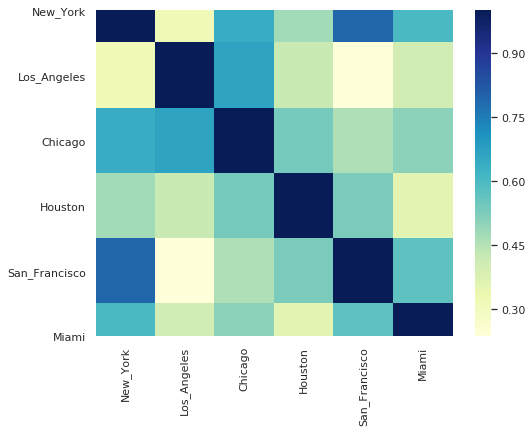

In [382]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.heatmap(Matrix_us_city, cmap="YlGnBu")

## Part 4.Challenge : 
### As the Foursquare API is personal free, the limit of the request is 500 radius and 100 venues. Thus our searched venues are only small part of the whole city, we need to find a method to coverage the whole city and obtain as many as venues from the city. So that the category is enough to encoding the feature.

### Parameter define

In [18]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
RADIUS = 500 # define Foursquare API request radius

lat_pads = 1 # pad latitude for each side
lng_pads = 1 # pad longitude for each side
lat_delta = 0.006 # pad latitude distance
lng_delta = 0.008 #pad longitude distance

### 4.1 Define a pad Function to cover the city

In [19]:
def coverCity(latitude, longitude):
    lats = np.zeros(shape=(lat_pads*2+1))
    lngs = np.zeros(shape=(lng_pads*2+1))
    lats[lat_pads] = latitude
    lngs[lng_pads] = longitude
    
    for i in range(lat_pads*2+1):
        lats[i] = lats[lat_pads]-(lat_pads-i)*lat_delta
    for i in range(lng_pads*2+1):
        lngs[i] = lngs[lng_pads]-(lng_pads-i)*lng_delta      
    
    return (lats, lngs)

#### Let's see how it covers NY and LA

In [16]:
lats_ny, lngs_ny = coverCity(latitude_NY,longitude_NY)

map_ny = folium.Map(location=[latitude_NY, longitude_NY], zoom_start=13)

for i in range(lat_pads*2+1):
    for j in range(lng_pads*2+1):
        lat = lats_ny[i]
        lng = lngs_ny[j]
        folium.Circle([lat, lng],radius=400,color='blue',
                      fill=True,fill_color='blue',fill_opacity=0.2).add_to(map_ny)

map_ny

In [17]:
lats_la, lngs_la = coverCity(latitude_LA,longitude_LA)

map_la = folium.Map(location=[latitude_LA, longitude_LA], zoom_start=13)

for i in range(lat_pads*2+1):
    for j in range(lng_pads*2+1):
        lat = lats_la[i]
        lng = lngs_la[j]
        folium.Circle([lat, lng],radius=400,color='blue',
                      fill=True,fill_color='blue',fill_opacity=0.2).add_to(map_la)

map_la

### 4.2 Find venues for each of the circle then combine them together and this would be the total venues from the city with whole categories

#### First let's define a Function to find venues in the padded city

In [20]:
def getNearbyVenues_padCity(name, lats, lngs, radius=RADIUS):
    
    venues_list=[]
    for i in range(len(lats)):
        for j in range(len(lngs)):
            lat = lats[i]
            lng = lngs[j]            
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
            k = 0
            while k<3:
                rreet=requests.get(url).json()
                if rreet['meta']['code'] == 200:
                    k =3
                    results = rreet["response"]['groups'][0]['items']
                    venues_list.append([(name, lat, lng, 
                                         v['venue']['id'], 
                                         v['venue']['name'], 
                                         v['venue']['location']['lat'], 
                                         v['venue']['location']['lng'], 
                                         v['venue']['categories'][0]['name']) for v in results])
                k+=1                    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['City', 'Circle Latitude', 'Circle Longitude', 'Venue Id','Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

#### Our circles have some overlapping and there must be some duplicates, we drop them and get the venues list of the padded city.

In [224]:
venues_whole_la = getNearbyVenues_padCity('LA', lats_la, lngs_la)

In [225]:
print(venues_whole_la.shape)
venues_whole_la.drop_duplicates(subset=['Venue Id'], inplace=True)
print(venues_whole_la.shape)
venues_whole_la.head()

(22837, 8)
(15851, 8)


City  Circle Latitude  Circle Longitude                  Venue Id  \
0   LA        33.933691       -118.402767  4b5b63f8f964a5202cfa28e3   
1   LA        33.933691       -118.402767  4b73c6adf964a52087bb2de3   
2   LA        33.933691       -118.402767  516c6b9f498e44df7fd96038   
3   LA        33.933691       -118.402767  4bafeeb5f964a520842c3ce3   
4   LA        33.933691       -118.402767  4c2273b29085d13afc5a86cc   

                           Venue Name  Venue Latitude  Venue Longitude  \
0  Flight Path Learning Center Museum       33.932137      -118.405278   
1            Embassy Suites by Hilton       33.930516      -118.400708   
2                     Runway 7R - 25L       33.934993      -118.406074   
3                   1440 Bistro & Bar       33.930591      -118.400527   
4             Atlantic Aviation (LAX)       33.932380      -118.398805   

            Venue Category  
0                   Museum  
1                    Hotel  
2          Airport Service  
3  New American Restaurant  
4         Airport Terminal

In [226]:
venues_whole_ny = getNearbyVenues_padCity('NY', lats_ny, lngs_ny)

In [227]:
print(venues_whole_ny.shape)
venues_whole_ny.drop_duplicates(subset=['Venue Id'], inplace=True)
print(venues_whole_ny.shape)
venues_whole_ny.head()

(35604, 8)
(23709, 8)


City  Circle Latitude  Circle Longitude                  Venue Id  \
0   NY        40.592728        -74.166015  4e3807436284fcf739a14c12   
1   NY        40.592728        -74.166015  4b316f69f964a520ef0625e3   
2   NY        40.592728        -74.166015  4bd423cf462cb713b7c5df07   
3   NY        40.592728        -74.166015  4fdf3bfb0039f72fcfa41cb8   
4   NY        40.592728        -74.166015  4b85d75ff964a520cb7531e3   

                        Venue Name  Venue Latitude  Venue Longitude  \
0                     Trader Joe's       40.589997       -74.165715   
1                 City Wine Cellar       40.591564       -74.164036   
2  Heartland Bagels - Richmond Ave       40.591464       -74.164186   
3              European Wax Center       40.591103       -74.164488   
4                   Holy Schnitzel       40.589778       -74.164390   

            Venue Category  
0            Grocery Store  
1             Liquor Store  
2               Bagel Shop  
3  Health & Beauty Service  
4               Restaurant

#### Then apply the previous work we can find the city similarties. Let's still write them in one function

In [21]:
def get_cities_feature(venues_city1, venues_city2):
    venues_comb = pd.concat([venues_city1, venues_city2], ignore_index=True)
    # one hot encoding
    onehot_comb = pd.get_dummies(venues_comb[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    onehot_comb['City'] = venues_comb['City'] 

    fixed_columns = [onehot_comb.columns[-1]] + list(onehot_comb.columns[:-1])
    onehot_comb = onehot_comb[fixed_columns]

    cities_grouped = onehot_comb.groupby('City').mean().reset_index()
    
    return cities_grouped

In [22]:
def paddedCity_similarity(city1='New York, NY, US', city2='Los Angeles, CA, US'):
    
    latitude_city1, longitude_city1 = get_city_coordinate(city1)
    latitude_city2, longitude_city2 = get_city_coordinate(city2)
    #print(latitude_city1, longitude_city1,latitude_city2, longitude_city2)
    
    lats_city1, lngs_city1 = coverCity(latitude_city1,longitude_city1)
    lats_city2, lngs_city2 = coverCity(latitude_city2,longitude_city2)
    #print(len(lats_city1), len(lats_city2))
    
    venues_whole_city1 = getNearbyVenues_padCity(city1, lats_city1, lngs_city1)
    venues_whole_city1.drop_duplicates(subset=['Venue Id'], inplace=True)
    venues_whole_city2 = getNearbyVenues_padCity(city2, lats_city2, lngs_city2)
    venues_whole_city2.drop_duplicates(subset=['Venue Id'], inplace=True)
    
    cities_grouped = get_cities_feature(venues_whole_city1, venues_whole_city2)
    cor_matrix = cities_grouped.set_index('City').transpose().corr()
    
    print('The similarity of city {} and city {} is {}.'.format(city1, city2, cor_matrix.iloc[0,1]))
    
    return cor_matrix

In [230]:
paddedCity_similarity('New York, NY, US', 'Los Angeles, CA, US')

The similarity of city New York, NY, US and city Los Angeles, CA, US is 0.6629298646638225.


City                 Los Angeles, CA, US  New York, NY, US
City                                                      
Los Angeles, CA, US              1.00000           0.66293
New York, NY, US                 0.66293           1.00000

## Part 5. Multi-City similarities and comparison

### 5.1 Load 55 top global cities

In [9]:
url = 'https://www.lboro.ac.uk/gawc/datasets/da6.csv'
global_cities = pd.read_csv(url, skiprows=range(1)).iloc[:,0:1]
print(global_cities.shape)
global_cities.head()

(55, 1)


CITIES
0  Amsterdam
1    Atlanta
2    Bangkok
3  Barcelona
4    Beijing

In [20]:
map_world_ = folium.Map()
for city in global_cities['CITIES']:
    lat_, lng_ = get_city_coordinate(city)
    label = city
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat_, lng_],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_world_) 
map_world_

#### We also need their countries to group them from same culture

In [24]:
df_country = pd.read_excel('https://www.lboro.ac.uk/gawc/datasets/da26_5.xlsx').iloc[:,0:2]
print(df_country.shape)
df_country.head()

(433, 2)


CITY              Country 
0   Aabenraa               Denmark
1    Aarhus                Denmark
2   Aberdeen        United Kingdom
3  Abu Dhabi  United Arab Emirates
4   Adelaide             Australia

### 5.2 Create DataFrame of global venues

In [25]:
# define the dataframe columns
column_names = ['City', 'Circle Latitude', 'Circle Longitude', 'Venue Id','Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

# instantiate the dataframe
venues_global = pd.DataFrame(columns=column_names)
print(venues_global.shape)

(0, 8)


#### Find all venues from each city

In [28]:
for city in global_cities['CITIES']:
    # print(city)
    latitude_city, longitude_city = get_city_coordinate(city)
    lats_city, lngs_city = coverCity(latitude_city,longitude_city)
    venues_whole_city = getNearbyVenues_padCity(city, lats_city, lngs_city)
    venues_whole_city.drop_duplicates(subset=['Venue Id'], inplace=True)
    
    venues_global= pd.concat([venues_global, venues_whole_city], ignore_index=True)

In [39]:
print('DataFrame contains {} unique cities'.format(len(venues_global.City.unique())))
venues_global.head()

DataFrame contains 55 unique cities


City  Circle Latitude  Circle Longitude                  Venue Id  \
0  Amsterdam         52.36854          4.889976  4a856313f964a52035fe1fe3   
1  Amsterdam         52.36854          4.889976  52af231b11d2d07f6e9bff9f   
2  Amsterdam         52.36854          4.889976  4a2bbd19f964a520db961fe3   
3  Amsterdam         52.36854          4.889976  5b0fa7e212f0a9002cb223cb   
4  Amsterdam         52.36854          4.889976  4b586efef964a520855728e3   

                 Venue Name  Venue Latitude  Venue Longitude  Venue Category  
0  The American Book Center       52.368911         4.889425       Bookstore  
1   Van Stapele Koekmakerij       52.368828         4.888481    Dessert Shop  
2                   Gartine       52.369157         4.891615  Breakfast Spot  
3              Bhatti Pasal       52.368055         4.890838      Restaurant  
4        Frens Haringhandel       52.367336         4.891121      Food Truck

### 5.3 One-Hot encoding, group and feature each city

In [60]:
# one hot encoding
onehot_global = pd.get_dummies(venues_global[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot_global['City'] = venues_global['City'] 

fixed_columns = [onehot_global.columns[-1]] + list(onehot_global.columns[:-1])
onehot_global = onehot_global[fixed_columns]

grouped_global = onehot_global.groupby('City').mean().reset_index()
grouped_global.set_index('City', inplace=True)
print(grouped_global.shape)
grouped_global.head()

(55, 592)


ATM  Abruzzo Restaurant  Acai House  Accessories Store  \
City                                                                
Amsterdam  0.0                 0.0         0.0           0.000000   
Atlanta    0.0                 0.0         0.0           0.000000   
Bangkok    0.0                 0.0         0.0           0.000000   
Barcelona  0.0                 0.0         0.0           0.004505   
Beijing    0.0                 0.0         0.0           0.000000   

           Adult Boutique  Advertising Agency  Afghan Restaurant  \
City                                                               
Amsterdam             0.0                 0.0                0.0   
Atlanta               0.0                 0.0                0.0   
Bangkok               0.0                 0.0                0.0   
Barcelona             0.0                 0.0                0.0   
Beijing               0.0                 0.0                0.0   

           African Restaurant  Airport Lounge  Airport Service  \
City                                                             
Amsterdam            0.001908             0.0              0.0   
Atlanta              0.000000             0.0              0.0   
Bangkok              0.000000             0.0              0.0   
Barcelona            0.001502             0.0              0.0   
Beijing              0.000000             0.0              0.0   

           Alsatian Restaurant  American Restaurant  Amphitheater  \
City                                                                
Amsterdam                  0.0             0.001908           0.0   
Atlanta                    0.0             0.040816           0.0   
Bangkok                    0.0             0.000000           0.0   
Barcelona                  0.0             0.001502           0.0   
Beijing                    0.0             0.000000           0.0   

           Animal Shelter  Antique Shop  Apple Wine Pub  Aquarium    Arcade  \
City                                                                          
Amsterdam             0.0           0.0             0.0       0.0  0.001908   
Atlanta               0.0           0.0             0.0       0.0  0.000000   
Bangkok               0.0           0.0             0.0       0.0  0.000000   
Barcelona             0.0           0.0             0.0       0.0  0.003003   
Beijing               0.0           0.0             0.0       0.0  0.000000   

           Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
City                                                                           
Amsterdam          0.000000                0.003817     0.009542    0.005725   
Atlanta            0.005102                0.000000     0.025510    0.000000   
Bangkok            0.000000                0.000000     0.007444    0.004963   
Barcelona          0.001502                0.004505     0.009009    0.003003   
Beijing            0.000000                0.000000     0.000000    0.000000   

           Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
City                                                                     
Amsterdam             0.001908                   0.0          0.007634   
Atlanta               0.000000                   0.0          0.000000   
Bangkok               0.000000                   0.0          0.027295   
Barcelona             0.001502                   0.0          0.006006   
Beijing               0.000000                   0.0          0.000000   

           Athletics & Sports  Auditorium  Australian Restaurant  \
City                                                               
Amsterdam            0.001908         0.0                    0.0   
Atlanta              0.000000         0.0                    0.0   
Bangkok              0.000000         0.0                    0.0   
Barcelona            0.000000         0.0                    0.0   
Beijing              0.000000         0.0                    

#### Sort Cities by their country

In [62]:
grouped_global = grouped_global.join(df_country.set_index('CITY'), on='City')
grouped_global.sort_values(by='Country ', inplace=True)
grouped_global.drop(['Country '], axis=1, inplace=True)
grouped_global.head()

ATM  Abruzzo Restaurant  Acai House  Accessories Store  \
City                                                                
Melbourne  0.0                 0.0    0.000000           0.000000   
Sydney     0.0                 0.0    0.000000           0.000000   
Sao Paulo  0.0                 0.0    0.002088           0.002088   
Toronto    0.0                 0.0    0.000000           0.000000   
Montreal   0.0                 0.0    0.000000           0.000000   

           Adult Boutique  Advertising Agency  Afghan Restaurant  \
City                                                               
Melbourne             0.0                 0.0                0.0   
Sydney                0.0                 0.0                0.0   
Sao Paulo             0.0                 0.0                0.0   
Toronto               0.0                 0.0                0.0   
Montreal              0.0                 0.0                0.0   

           African Restaurant  Airport Lounge  Airport Service  \
City                                                             
Melbourne            0.001919             0.0              0.0   
Sydney               0.000000             0.0              0.0   
Sao Paulo            0.000000             0.0              0.0   
Toronto              0.000000             0.0              0.0   
Montreal             0.000000             0.0              0.0   

           Alsatian Restaurant  American Restaurant  Amphitheater  \
City                                                                
Melbourne                  0.0             0.000000           0.0   
Sydney                     0.0             0.000000           0.0   
Sao Paulo                  0.0             0.002088           0.0   
Toronto                    0.0             0.007353           0.0   
Montreal                   0.0             0.000000           0.0   

           Animal Shelter  Antique Shop  Apple Wine Pub  Aquarium  Arcade  \
City                                                                        
Melbourne             0.0      0.001919             0.0       0.0     0.0   
Sydney                0.0      0.000000             0.0       0.0     0.0   
Sao Paulo             0.0      0.000000             0.0       0.0     0.0   
Toronto               0.0      0.001838             0.0       0.0     0.0   
Montreal              0.0      0.000000             0.0       0.0     0.0   

           Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
City                                                                           
Melbourne               0.0                0.003839     0.009597    0.000000   
Sydney                  0.0                0.000000     0.000000    0.004082   
Sao Paulo               0.0                0.000000     0.014614    0.004175   
Toronto                 0.0                0.000000     0.011029    0.001838   
Montreal                0.0                0.000000     0.000000    0.000000   

           Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
City                                                                     
Melbourne             0.000000                   0.0          0.011516   
Sydney                0.000000                   0.0          0.012245   
Sao Paulo             0.020877                   0.0          0.004175   
Toronto               0.005515                   0.0          0.003676   
Montreal              0.000000                   0.0          0.000000   

           Athletics & Sports  Auditorium  Australian Restaurant  \
City                                                               
Melbourne            0.001919         0.0               0.011516   
Sydney               0.000000         0.0               0.040816   
Sao Paulo            0.000000         0.0               0.000000   
Toronto              0.000000         0.0               0.000000   
Montreal             0.000000         0.0               0.000000   

      

In [65]:
grouped_global.drop_duplicates(inplace=True)
grouped_global.shape

(55, 592)

### 5.4 Check correlations of each city

In [68]:
Matrix_global=grouped_global.transpose().corr()
print(Matrix_global.shape)
Matrix_global.head()

(55, 55)


City       Melbourne    Sydney  Sao Paulo   Toronto  Montreal  Santiago  \
City                                                                      
Melbourne   1.000000  0.683399   0.530738  0.727854  0.470885 -0.009494   
Sydney      0.683399  1.000000   0.431671  0.443455  0.373293  0.052410   
Sao Paulo   0.530738  0.431671   1.000000  0.462002  0.409040  0.090964   
Toronto     0.727854  0.443455   0.462002  1.000000  0.473767  0.059219   
Montreal    0.470885  0.373293   0.409040  0.473767  1.000000  0.030930   

City        Beijing  Shanghai  Hong Kong    Prague  Copenhagen     Paris  \
City                                                                       
Melbourne  0.328485  0.510720   0.721911  0.704148    0.741252  0.428578   
Sydney     0.251044  0.367847   0.545583  0.749369    0.573798  0.363610   
Sao Paulo  0.132664  0.247128   0.489395  0.502353    0.509153  0.330248   
Toronto    0.462164  0.551045   0.659659  0.598622    0.713022  0.411983   
Montreal   0.256498  0.258573   0.371775  0.368034    0.466190  0.283681   

City         Berlin    Munich   Hamburg  Budapest   Jakarta      Rome  \
City                                                                    
Melbourne  0.615552  0.683785  0.505683  0.547095  0.481579  0.371101   
Sydney     0.580896  0.647555  0.432798  0.572911  0.378670  0.419392   
Sao Paulo  0.462636  0.511563  0.411317  0.440659  0.267734  0.363162   
Toronto    0.648635  0.559203  0.570464  0.530588  0.554522  0.357102   
Montreal   0.347278  0.325605  0.364436  0.375549  0.348199  0.113169   

City          Milan     Tokyo     Osaka  Kuala Lumpur  Mexico City  Amsterdam  \
City                                                                            
Melbourne  0.540806  0.554110  0.149257      0.566689     0.333990   0.644177   
Sydney     0.515653  0.482796  0.130035      0.480887     0.279687   0.547220   
Sao Paulo  0.482254  0.443663  0.158581      0.305828     0.333835   0.487037   
Toronto    0.464838  0.496540  0.126845      0.524560     0.367288   0.617614   
Montreal   0.233306  0.311081  0.361605      0.295172     0.229995   0.379238   

City         Manila    Warsaw    Moscow  Singapore  Johannesburg     Seoul  \
City                                                                         
Melbourne  0.405377  0.739317  0.466733   0.262808     -0.009494  0.719551   
Sydney     0.328171  0.614653  0.337167   0.336649      0.004157  0.370223   
Sao Paulo  0.290637  0.546232  0.380765   0.189592      0.036835  0.312319   
Toronto    0.375417  0.737862  0.592434   0.197942      0.008411  0.599740   
Montreal   0.315755  0.407953  0.327931   0.185500      0.080151  0.299583   

City         Madrid  Barcelona  Stockholm    Zurich    Geneva   Bangkok  \
City                                                                      
Melbourne  0.496047   0.468804   0.587866  0.670378  0.636975  0.621767   
Sydney     0.470706   0.408024   0.619717  0.583750  0.502084  0.520935   
Sao Paulo  0.412311   0.344257   0.411947  0.509414  0.506245  0.373589   
Toronto    0.430689   0.448912   0.521092  0.560783  0.541998  0.527426   
Montreal   0.246709   0.236602   0.366197  0.371056  0.381847  0.400365   

City         London   Atlanta    Boston   Chicago    Dallas   Houston  \
City                                                                    
Melbourne  0.634236  0.371772  0.541428  0.504076  0.575346  0.601968   
Sydney     0.484301  0.242489  0.536114  0.398839  0.426592  0.427495   
Sao Paulo  0.451864  0.264443  0.436576  0.382641  0.355408  0.349660   
Toronto    0.751760  0.488400  0.623914  0.700505  0.633430  0.592039   
Montreal   0.389178  0.384320  0.335721  0.407656  0.395596  0.360058   

City       New York  Los Angeles  Minneapolis     Miami  San Francisco  \
City                                                                     
Melbourne  0.638746     0.591109     0.597843  0.582027       0.646242   
Sydney     0.499044     0.392370     0.383884  0.52005

#### Plot a Heat-map to see their relations

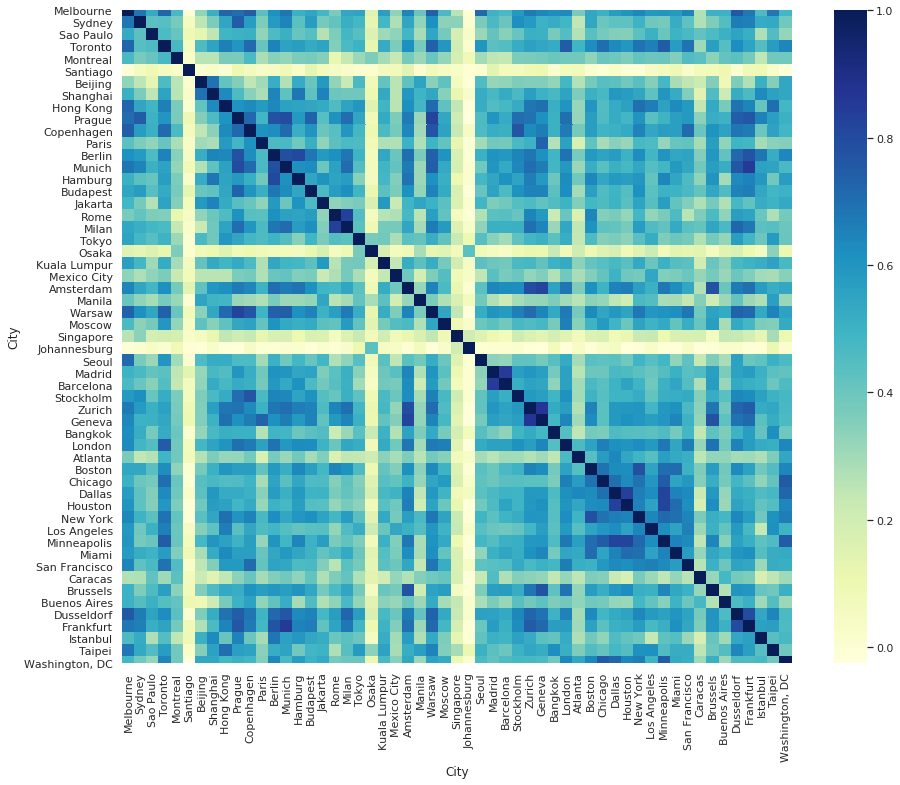

In [67]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)})
ax = sns.heatmap(Matrix_global, cmap="YlGnBu")